# Detecting the Oklahoma earthquake using twitter

Thomas Aarholt (2016)
 
This is a notepad that I used to demonstrate how twitter data can possibly be used to monitor earthquakes. It is an exercise in acquiring data, filtering it, and then performing curve fitting with some foreknowledge of the data system.

The earthquake was the September 3rd 2016 Oklahoma earthquake: https://en.wikipedia.org/wiki/2016_Oklahoma_earthquake

At best, I was able to get within 9 km of what google says is the point of origin (epicenter) of the earthquake. In this notebook, I use an ODR fitting approach with a 2D cone to estimate the speed of the "tweet wave" to be about 1.5 km/s and the average delay to tweeting afterwards to be about 4 minutes.

### Login to twitter and Python imports

In [1]:
%matplotlib inline
from importlib import reload
import twitter
import json
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance
from mpl_toolkits.mplot3d import Axes3D
import time
import collections
import scipy.optimize as opt
import scipy.stats
import scipy.io
from scipy.odr import ODR, Model, Data, RealData
from datetime import datetime
#reload(mpl_toolkits.basemap)
from mpl_toolkits.basemap import Basemap

oklahoma = (-97, 35)
import mpl_toolkits.basemap
#mpl_toolkits.basemap.__version__

#quakeGPS = [Lat, Long,] == [N, E]


termOklahoma = "quake OR earthquake OR shake OR shaking"
quakeGPSOklahoma = [36.425, -96.929]
untilOklahoma = "2016-09-04"
sinceOklahoma = "2016-09-03 12:02:44"


In [ ]:
consumer_key = "GetYourOwn"
consumer_secret = "GetYourOwn"
access_token = "GetYourOwn"
access_token_secret = "GetYourOwn"

api = twitter.Api(consumer_key=consumer_key,
                  consumer_secret=consumer_secret,
                  access_token_key=access_token,
                  access_token_secret=access_token_secret)

In [ ]:
def searchtweets(api, term, since, until, maxID=np.inf):
    import numpy as np
    results = api.GetSearch(
    term=term, since=since,until=until, 
    count=100, result_type="recent")
    max_id = np.inf
    for tweet in results:
        if tweet.id < max_id:
            max_id = tweet.id
    return(results, max_id)

In [ ]:
len(results)

In [ ]:
while results[-1].created_at_in_seconds > since:
    try:
        newresults, max_id = searchtweets(api=api, term=term, since=None, until=None, maxID=max_id)
    except:
        print(str(len(results)) + " results so far!")
        print("Latest entry from: " + str(datetime.fromtimestamp(results[-1].created_at_in_seconds)))
        for i in range(len(results)):
            results[i].user = None
            results[i].retweeted_status = None
            results[i].source = None
        gc.collect()
        print(str(datetime.now().time())[:8] + ": Sleeping 15 min")
        time.sleep(15*60)
        print("\nResuming")
    else:
        results.extend(newresults)
len(results)

In [2]:
def epochtomytime(epoch, full=True):
    import time
    if full == True:
        pattern = "%Y-%m-%d %H:%M:%S"
    else:
        pattern = "%Y-%m-%d"
    mytime = time.strftime(pattern, time.localtime(epoch))
    print(mytime)
    return mytime

In [3]:
def timetoepoch(mytime):
    import time
    if len(mytime) > 10:
        pattern = "%Y-%m-%d %H:%M:%S"
    else:
        pattern = "%Y-%m-%d"
    epoch = int(time.mktime(time.strptime(mytime, pattern)))

    print(epoch)
    return epoch

In [ ]:
results_dict = [tweet.AsDict() for tweet in results]
# SAVE
with open('global_southkorea_12sep_cleaned.txt', 'w') as outfile:
    json.dump(results_dict, outfile)
results_dict = None

In [4]:
# LOAD 
lines_of_jsondict = json.load(open("Oklahoma_cleaned.txt"))
results = []
for jsondict in lines_of_jsondict:
    results.append(twitter.models.Status.NewFromJsonDict(jsondict))
results_dict = None
import gc
gc.collect()


0

In [5]:
for i in range(len(results)):
    results[i].user = None
    results[i].retweeted_status = None
    results[i].source = None

In [6]:
results_dict = [tweet.AsDict() for tweet in results]
# SAVE
with open('Oklahoma_cleaned.txt', 'w') as outfile:
    json.dump(results_dict, outfile)
results_dict = None

In [5]:
def plot_histogram(list_of_tweets, time_zero=0, croptominutes = 0, resolution="minute"):
    import numpy as np
    
    fontsize = 15
    
    times = np.array([tweet.created_at_in_seconds for tweet in list_of_tweets])
    times = times - time_zero
    if croptominutes != 0:
        print(times.shape)
        i = np.where(times <= 0)[0][0]
        j = np.where(times >= croptominutes*60)[0][-1]
        print(i,j)
        times = times[j:i]
    
    if resolution == "second":
        divisor = 1
    elif resolution == "minute":
        divisor = 60
    elif resolution == "hour":
        divisor = 60*60
    elif resolution == "day":
        divisor = 60*60*24
    else:
        divisor = 60
    
    times = np.divide(times,divisor) # from seconds into hours
    
    
    hist, bins = np.histogram(times, bins=int((times[0]-times[-1])))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    fig, ax = plt.subplots(1, figsize=(10,4))
    ax.plot(center, hist, lw=4)
    plt.xlabel("Time since quake ({}s)".format(resolution), size=fontsize)
    plt.ylabel("Tweets per minute", size=fontsize)
    plt.xticks(size=fontsize)
    plt.yticks(size=fontsize)
    return (fig, ax), (hist, bins), resolution

def plot_grad(hist, bins, resolution):
    fontsize = 15
    fig, ax = plt.subplots(1, figsize=(10,3))
    line = ax.plot(bins[1:],np.gradient(hist))
    #plt.xlim(-6,12)
    #plt.ylim(0,None)
    plt.xlabel("Time since quake ({}s)".format(resolution), size=fontsize)
    plt.ylabel("Rate of change of tweets per minute", size=fontsize)
    plt.xticks(size=fontsize)
    plt.yticks(size=fontsize)

### Plotting the tweets involving variations of the term "Earthquake" or "shaking" around the time of the occurence of the earthquake

In [6]:
import seaborn as sns

sns.set_style("darkgrid")

1472896964


(0, 20)

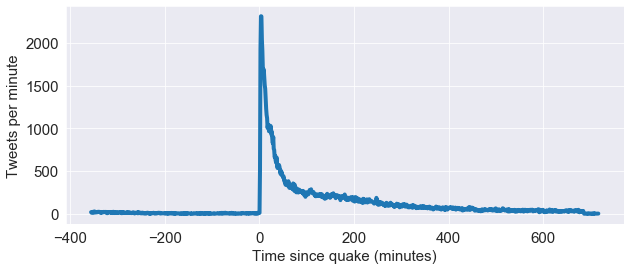

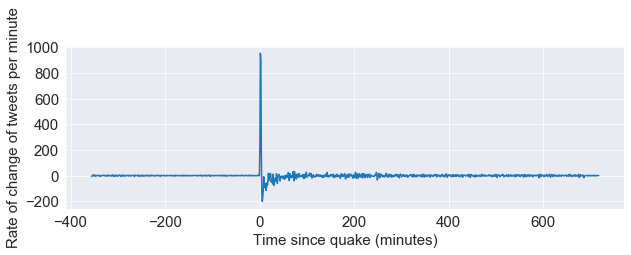

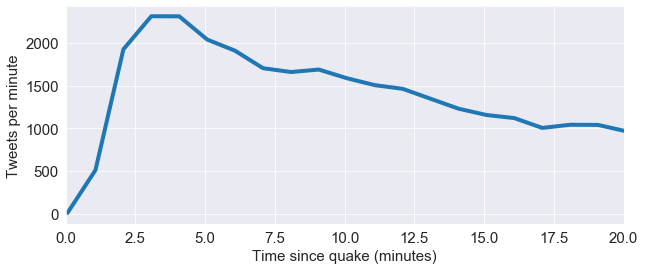

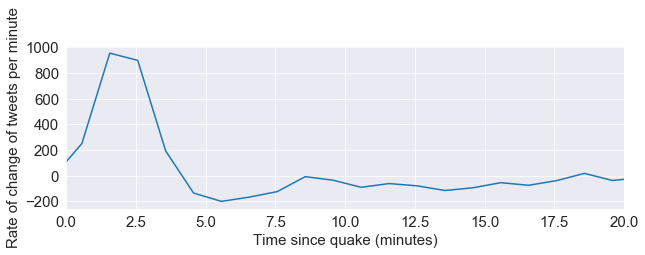

In [7]:
%matplotlib inline
since = timetoepoch(sinceOklahoma)+120*60

resolution = "minute"
if resolution == "second":
    twentyminutes = 20*60
elif resolution == "minute":
    twentyminutes = 20
else: 
    twentyminutes = 1/3

(fig1, ax), (hist, bins), resolution = plot_histogram(
    results, time_zero=since, resolution=resolution)
plot_grad(hist, bins, resolution=resolution)
fig1.savefig("tweetspermin.png", dpi=800, bounding_box="tight")
(fig2, ax), (hist, bins), resolution = plot_histogram(
    results, time_zero=since, resolution=resolution)

plt.xlim(0,twentyminutes)

plot_grad(hist, bins, resolution=resolution)
plt.xlim(0,twentyminutes)




## Select only tweets that happened from start of the earthquake until t minutes after

In [8]:
quakeGPS = quakeGPSOklahoma
geo = {
    "places" : [],
    "times" : [],
    "results" : [],
    "radius" : [],
    "places_uncertainty" : [],
}
start = since # Time of quake

for tweet in results:
    # Try exact GPS coordinates
    if tweet.place != None:
        if tweet.coordinates != None:
            the_time = (tweet.created_at_in_seconds - start)/60
            if 0 <= the_time <=20:
                location = tweet.coordinates["coordinates"]
                uncertainty = [0.000001,0.000001]
                radius = geopy.distance.vincenty(quakeGPS, location[::-1]).kilometers
                geo["places"].append(location)
                geo["places_uncertainty"].append(uncertainty)
                geo["times"].append(the_time)
                geo["results"].append(tweet)
                geo["radius"].append(radius)
        else:
            # If not exact coordinates, try location!
            the_time = (tweet.created_at_in_seconds - start)/60
            if 0 <= the_time <=20:
                location = np.mean(tweet.place["bounding_box"]["coordinates"][0], axis=0)
                uncertainty = scipy.stats.sem(tweet.place["bounding_box"]["coordinates"][0], axis=0)
                radius = geopy.distance.vincenty(quakeGPS, location[::-1]).kilometers
                geo["places"].append(location)
                geo["places_uncertainty"].append(uncertainty)
                geo["times"].append(the_time)
                geo["results"].append(tweet)
                geo["radius"].append(radius)

print("Number of tweets with location: " + str(len(geo["places"])))
# Remove reweets - RT


for i, tweet in enumerate(geo["results"]):
    if "RT" in tweet.text or "@" in tweet.text:
        geo["results"].pop(i)
        geo["times"].pop(i)
        geo["places"].pop(i)
        geo["radius"].pop(i)

for key in geo:
    geo[key] = np.array(geo[key])
print("Number of tweets with location after filtering: " + str(len(geo["results"])))

C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


Number of tweets with location: 4445
Number of tweets with location after filtering: 3799


### We can see the locations of cities based on the horizontal lines depicting the radius of people's location from Google's estimate of where the earthquake happened

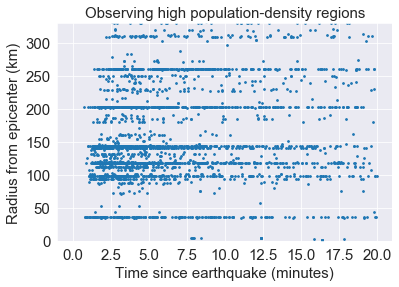

In [9]:
fontsize = 15
fig = plt.figure()
plt.scatter(geo["times"], geo["radius"], s=3)
plt.ylim(0,330)
plt.title("Observing high population-density regions", size=fontsize)
plt.xlabel("Time since earthquake (minutes)", size=fontsize)
plt.ylabel("Radius from epicenter (km)", size=fontsize)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
fig.savefig("tweetsandcities.png", dpi=800, bounding_box="tight")

In [10]:
# Remove duplicates i.e. people from the same city, keeping only earliest record of tweet
stringedlocation = [str(x[0])+str(x[1]) for x in np.round(geo["places"],3)]
uniques = collections.Counter(stringedlocation).keys() # 

filtered_time = []
filtered_location = []
filtered_radius = []
filtered_uncertainty = []
for location in uniques:
    t = 1000
    for i, entry in enumerate(stringedlocation):
        if location in entry:
            if t > geo["times"][i]:
                t = geo["times"][i]
                j = i
    filtered_time.append(t)
    filtered_location.append(geo["places"][j]) # 
    filtered_radius.append(geo["radius"][j])
    filtered_uncertainty.append(geo["places_uncertainty"][j])
geo["filtered_uncertainty"] = np.array(filtered_uncertainty)
geo["filtered_time"] = np.array(filtered_time)
geo["filtered_location"] = np.array(filtered_location)
geo["filtered_radius"] = np.array(filtered_radius)
len(geo["filtered_radius"])

384

In [11]:
X = [x[0] for x in geo["filtered_location"]]
Y = [x[1] for x in geo["filtered_location"]]
Z = geo["filtered_time"]
R = geo["filtered_radius"]

### Plotting the XY location against time (y-axis) after filtering the tweets for non-relevant entries

In [32]:
%matplotlib inline # interactive not working right now


(31.424999999999997, 41.425)

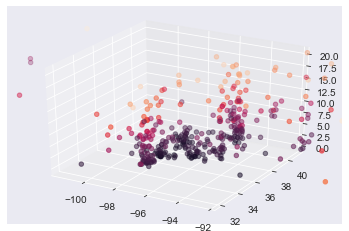

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z,c=Z)

ax.set_xlim(quakeGPS[1]-5,quakeGPS[1]+5)
ax.set_ylim(quakeGPS[0]-5,quakeGPS[0]+5)

I tried a few different models to represent the earthquake wave moving out, but settled on a 2D cone!

In [15]:
def gaussian(xytuple,A,x0,y0,stdx,stdy,c):
    """Returns a gaussian function with the given parameters"""
    import numpy as np
    x,y = xytuple
    X = ((x-x0)**2)/(2*stdx**2)
    Y = ((y-y0)**2)/(2*stdy**2)
    z = A*np.exp(-(X+Y))+c
    return z

In [16]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y,offset, theta=0):
    import numpy as np
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

In [17]:
oklahoma = (-97, 35)

X = [x[0] for x in geo["places"]]
Y = [x[1] for x in geo["places"]]
Xunc = [x[0] for x in geo["places_uncertainty"]]
Yunc = [x[1] for x in geo["places_uncertainty"]]
Z = geo["times"]

In [18]:
# 2D Cone function
def cone(xytuple,a,x0,y0,c):
    (x,y,) = xytuple
    return a*((x-x0)**2+(y-y0)**2)**(1/2) + c

popt,pcov = opt.curve_fit(cone, (X,Y), Z,
                          p0 = [1,quakeGPS[1],quakeGPS[0],1],
                          bounds=[
        [0,np.min(X),np.min(Y), 0],
        [20,np.max(X), np.max(Y),10]
    ])

estquakeGPS = [popt[2], popt[1]]
print("Estimated epicenter: " + str(estquakeGPS))
print("Missed by " + str(round(geopy.distance.vincenty(quakeGPS, estquakeGPS).kilometers,2)) + " km")
print("Estimated delay before tweets: " + str(round(popt[-1],2)))
print("Estimated speed: " + str(round(popt[0],2)))


Estimated epicenter: [36.22340062307368, -97.84003753361051]
Missed by 84.81 km
Estimated delay before tweets: 6.17
Estimated speed: 0.57


C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  from ipykernel import kernelapp as app


In [19]:
def coneodr(beta,xytuple,):
    a,x0,y0,c = beta
    [x,y] = xytuple
    return a*((x-x0)**2+(y-y0)**2)**(1/2) + c

In [26]:
bin_means

[14.458333333333334,
 nan,
 2.193333333333333,
 6.199999999999999,
 2.916666666666667,
 2.769047619047619,
 2.9424242424242424,
 2.9236842105263157,
 3.263888888888889,
 3.0055555555555555,
 4.295833333333333,
 3.6111111111111107,
 2.909090909090909,
 3.604166666666667,
 5.918749999999999,
 5.325,
 7.042592592592594,
 3.5444444444444447,
 6.583333333333333,
 8.608333333333333]

C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


y=0.019529x+0.69
Speed of shake = 0.85km/s


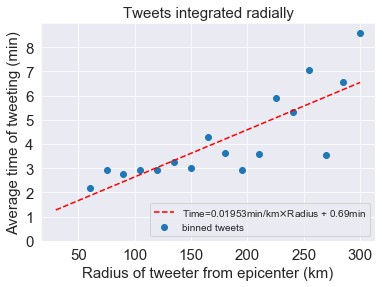

In [29]:
fontsize = 15

nbins = 21
bins = list(np.linspace(0,300,nbins))

digitized = np.digitize(geo["filtered_radius"], bins)
bin_means = [geo["filtered_time"][digitized == i].mean() for i in range(1, len(bins))]

#manually pop entries 0 and 3 because they are anomalies
bin_means.pop(3)
bins.pop(3)
bin_means.pop(0)
bins.pop(0)

x = np.array(bins[1:])
y = np.array(bin_means)
fig, ax = plt.subplots(1)
ax.scatter(x, y, label="binned tweets")

isnotnan = np.isfinite(x) & np.isfinite(y)
z = np.polyfit(x[isnotnan], y[isnotnan], 1,)
p = np.poly1d(z)
fit_label = "Time=" + str(round(z[0]*100000)/100000) + r"min/km$\times$Radius + " + str(round(z[1]*100)/100) + "min"
plt.plot(x,p(x),"r--", label=fit_label)

print ("y=%.6fx+%.2f"%(z[0],z[1]))
plt.title("Tweets integrated radially", size=fontsize)
plt.ylabel("Average time of tweeting (min)", size=fontsize)
plt.xlabel("Radius of tweeter from epicenter (km)", size=fontsize)
plt.legend(loc=4)
plt.ylim(0, None)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
    
fig.savefig("Speed of shake.png", bounding_box="tight", dpi=800)
print("Speed of shake = " + str(round((1/z[0])/60,2)) + "km/s")



## Take a quick look at the data

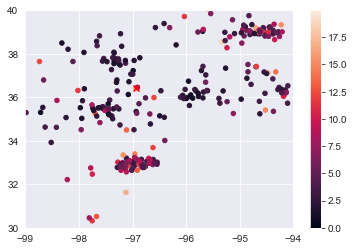

In [30]:
quakeGPS = quakeGPSOklahoma
lat = [coord[1] for coord in geo["filtered_location"]]
lon = [coord[0] for coord in geo["filtered_location"]]
#Lon should be negative
lon[0:2]

%matplotlib inline
fig, ax = plt.subplots()

cax = ax.scatter(lon, lat, c=geo["filtered_time"], s=20,)
ax.scatter(quakeGPS[1], quakeGPS[0], c="r", marker="x", linewidths=20,)
plt.xlim(-99, -94)
plt.ylim(30, 40)
cbar = fig.colorbar(cax,)

[-97.68  32.48]
[-96.93  36.42]
[-96.53  33.52]
Best startingpoint is  [-95.98717635, 36.65767425]
Estimated epicenter: [36.578542970524154, -96.55053046082038]
Missed by 37.95 km
Estimated delay before tweets: 4.83
Estimated speed: 1.68


C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


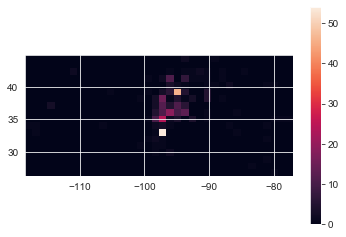

In [31]:
y = [a[1] for a in geo["filtered_location"]]
x = [a[0] for a in geo["filtered_location"]]

n = 10

H, xedges, yedges = np.histogram2d(x,y, 
                                   bins=[int(360/n),int(180/n)], 
                                   range=[[min(x),max(x)],[min(y),max(y)]],
                                  )
H = np.rot90(H)
H = np.flipud(H)
im = plt.imshow(H, interpolation='nearest', origin="lowest",clim = (H.min(),H.max()), 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()

i,j = np.unravel_index(H.argmax(), H.shape)

print(np.round((xedges[j],yedges[i]),2))
print(np.round(quakeGPS[::-1],2))
print(np.round((xedges[j+1],yedges[i+1]),2))
startingpoint = np.mean([[xedges[j],yedges[i]], [xedges[j+1],yedges[i+1]]], axis=0)
startingpoint = [np.median(x), np.median(y)]
print("Best startingpoint is ", startingpoint)


#generate data

realdata = RealData(x=[X,Y], y=Z,)
model = Model(coneodr)

odr = ODR(realdata, model, beta0=[1,startingpoint[0],startingpoint[1], 1])
odr.set_job(fit_type=0)
output = odr.run()
beta = output.beta
odrA = output.beta[0]
odrEpicenter = [output.beta[2], output.beta[1]]
odrc = output.beta[3]
print("Estimated epicenter: " + str(odrEpicenter))
print("Missed by " + str(round(geopy.distance.vincenty(quakeGPS, odrEpicenter).kilometers,2)) + " km")
print("Estimated delay before tweets: " + str(round(odrc,2)))
print("Estimated speed: " + str(round(odrA,2)))

In [112]:
# # 3D plot
# fig = plt.figure()
# x = np.linspace(oklahoma[0]-10,oklahoma[0]+10)
# y = np.linspace(oklahoma[1]-10,oklahoma[1]+10)
# x, y = np.meshgrid(x,y)
# z = coneodr(beta,(x,y),)

# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z)
# ax.scatter(X,Y,Z,c=Z)
# #pcm = ax.pcolormesh(X, Y, Z, vmin=0., vmax=10., cmap='RdBu_r')
# R = 5
# plt.xlim(oklahoma[0]-R,oklahoma[0]+R)
# plt.ylim(oklahoma[1]-R,oklahoma[1]+R)

In [113]:
mapmin = np.min(geo["places"], axis=0)
mapmax = np.max(geo["places"], axis=0)

C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instea

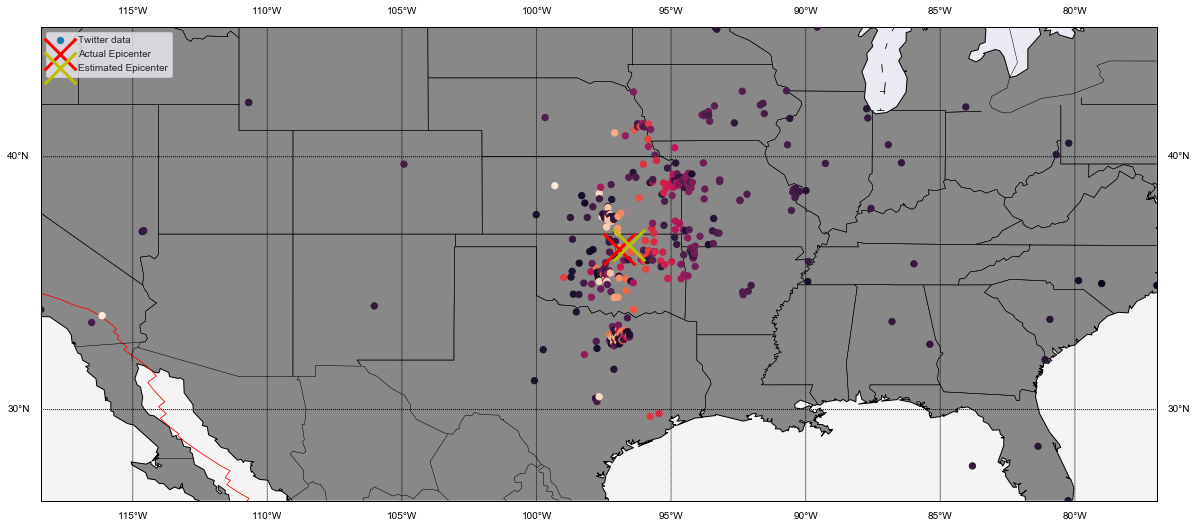

In [114]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(20,10))
colorarray = geo["filtered_time"]
# Create a map, using the Gall–Peters projection, 
map = Basemap(
    urcrnrlat=mapmax[1],
    urcrnrlon=mapmax[0],
    llcrnrlat=mapmin[1],
    llcrnrlon=mapmin[0],
    projection='gall', 
    # with low resolution,
    resolution = 'l', 
    # And threshold 100000
    area_thresh = 100000.0,


)


# Draw the coastlines on the map
map.drawcoastlines()
map.readshapefile('tectonicplates-master/PB2002_plates', 
                name='tectonic_plates', 
                drawbounds=True, 
                color='red')


# Draw country borders on the map
map.drawcountries()
map.drawstates()

# Fill the land with grey
map.fillcontinents(color = '#888888')


# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')

meridians = np.arange(0,360.,5.)
parallels = np.arange(-190,90.,10.)


map.drawmeridians(meridians, labels=[True, True, True, True])
map.drawparallels(parallels, labels=[True, True, True, True])



# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
#x,y = map(df['longitude'].values, df['latitude'].values)

x, y = list(zip(*sorted(zip(lon, lat), key=lambda it: it[0])))
# Plot them using round markers of size 6
myplot = map.scatter(x=x, y=y, latlon=True, marker="o", zorder=10, c=colorarray, s=40, label="Twitter data")
epicenter = map.scatter(
    quakeGPS[1], quakeGPS[0], latlon=True, marker="x", linewidth=3, s=1000, color="r", zorder=10, label="Actual Epicenter")
#est = map.scatter(estquakeGPS[0], estquakeGPS[1], latlon=True, marker="x",linewidth=3, s=1000, color="b", zorder=10,)
odr = map.scatter(
    odrEpicenter[1], odrEpicenter[0], latlon=True, marker="x",linewidth=3, s=1000, color="y", zorder=10, label="Estimated Epicenter")
#map.warpimage(image="gebco_08_rev_bath_3600x1800_color.jpg", scale=1)


#cbar = map.colorbar(myplot,location='bottom',pad="5%")
#cbar.set_label("Minutes since Earthquake")
#plt.title("Tweets messaging 'Earthquake' minutes after the September 2016 Oklahoma earthquake")
# Show the map
plt.legend()
plt.show()

C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


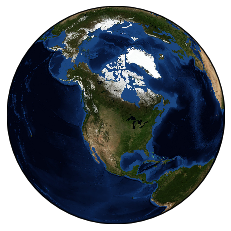

In [97]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
map = Basemap(projection='ortho', lat_0 = 50, lon_0 = -100,
              resolution = 'l', area_thresh = 1000.)
map.warpimage()

map.drawmapboundary()
plt.show()

In [98]:
lon = [coord[0] for coord in geo["places"]]
lat = [coord[1] for coord in geo["places"]]

In [100]:
print(geopy.distance.vincenty(quakeGPS, odrEpicenter).km)

37.94694135674972


C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """Entry point for launching an IPython kernel.


C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instea

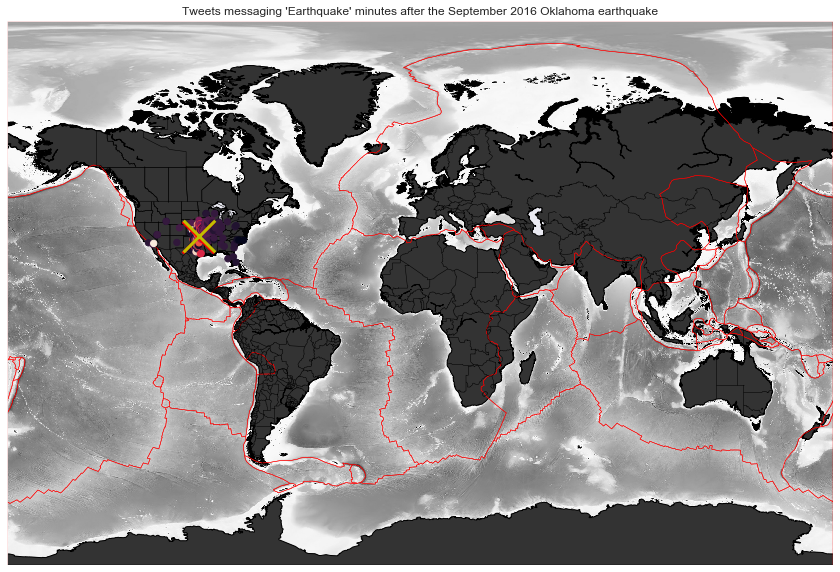

In [115]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(20,10))
colorarray = geo["filtered_time"]
# Create a map, using the Gall–Peters projection, 
map = Basemap(
    urcrnrlat=90,
    urcrnrlon=180,
    llcrnrlat=-80,
    llcrnrlon=-180,
    projection='mill', 
    # with low resolution,
    resolution = 'l', 
    # And threshold 100000
    area_thresh = 100000.0,
)
map.warpimage(image="sepia.jpg", scale=1)


# Draw the coastlines on the map
map.drawcoastlines()
map.readshapefile('tectonicplates-master/PB2002_plates', 
                name='tectonic_plates', 
                drawbounds=True, 
                color='red')

# Draw country borders on the map
map.drawcountries()
map.drawstates()
# Fill the land with grey
map.fillcontinents(color = '#333333');

# Draw the map boundaries
#map.drawmapboundary()

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
#x,y = map(df['longitude'].values, df['latitude'].values)
x, y = list(zip(*sorted(zip(lon, lat), key=lambda it: it[0])))
# Plot them using round markers of size 6
myplot = map.scatter(x=x, y=y, latlon=True, marker="o", zorder=10,  s=40,c=colorarray,)
epicenter = map.scatter(quakeGPS[1], quakeGPS[0], latlon=True, marker="x", linewidth=3, s=1000, color="r", zorder=10,)
#est = map.scatter(estquakeGPS[1], estquakeGPS[0], latlon=True, marker="x",linewidth=3, s=1000, color="b", zorder=10,)
est = map.scatter(odrEpicenter[1], odrEpicenter[0], latlon=True, marker="x",linewidth=3, s=1000, color="y", zorder=10,)
#map.warpimage(image="gebco_08_rev_bath_A1_grey_geo.tif", scale=1)

#cbar = map.colorbar(myplot,location='bottom',pad="5%")
#cbar.set_label("Minutes since Earthquake")
plt.title("Tweets messaging 'Earthquake' minutes after the September 2016 Oklahoma earthquake")
# Show the map
plt.show()

C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instea

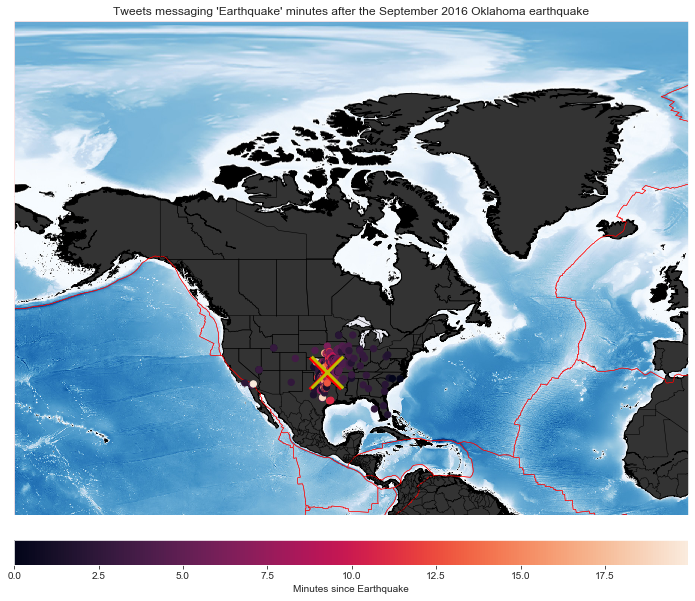

In [116]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(20,10))
colorarray = geo["filtered_time"]
# Create a map, using the Gall–Peters projection, 
map = Basemap(
    urcrnrlat=90,
    urcrnrlon=0,
    llcrnrlat=0,
    llcrnrlon=-180,
    projection='mill', 
    # with low resolution,
    resolution = 'l', 
    # And threshold 100000
    area_thresh = 100000.0,
)
map.warpimage(image="gebco_08_rev_bath_3600x1800_color.jpg", scale=1)


# Draw the coastlines on the map
map.drawcoastlines()
map.readshapefile('tectonicplates-master/PB2002_plates', 
                name='tectonic_plates', 
                drawbounds=True, 
                color='red')

# Draw country borders on the map
map.drawcountries()
map.drawstates()
# Fill the land with grey
map.fillcontinents(color = '#333333')

# Draw the map boundaries
#map.drawmapboundary()

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
#x,y = map(df['longitude'].values, df['latitude'].values)

x, y = list(zip(*sorted(zip(lon, lat), key=lambda it: it[0])))
# Plot them using round markers of size 6
myplot = map.scatter(x=x, y=y, latlon=True, marker="o", zorder=10, c=colorarray, s=40)
epicenter = map.scatter(quakeGPS[1], quakeGPS[0], latlon=True, marker="x", linewidth=3, s=1000, color="r", zorder=10,)
#est = map.scatter(estquakeGPS[1], estquakeGPS[0], latlon=True, marker="x",linewidth=3, s=1000, color="b", zorder=10,)
est = map.scatter(odrEpicenter[1], odrEpicenter[0], latlon=True, marker="x",linewidth=3, s=1000, color="y", zorder=10,)
#map.warpimage(image="gebco_08_rev_bath_A1_grey_geo.tif", scale=1)

cbar = map.colorbar(myplot,location='bottom',pad="5%")
cbar.set_label("Minutes since Earthquake")
plt.title("Tweets messaging 'Earthquake' minutes after the September 2016 Oklahoma earthquake")
# Show the map
plt.show()

C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(54,
 5,
 [-180.0, -89.99999999999994, 0.0, 0.0],
 [180.00000000000023, 90.0, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x21695706710>)

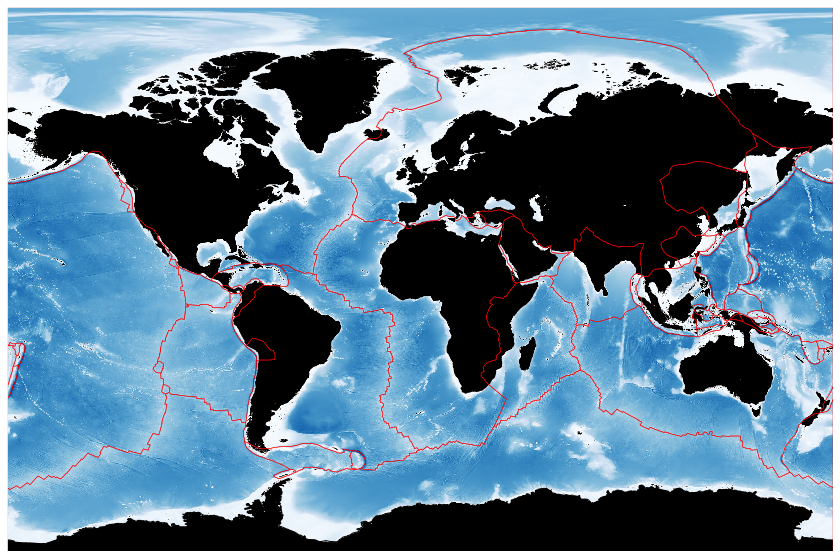

In [117]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(20,10))
colorarray = geo["filtered_time"]
# Create a map, using the Gall–Peters projection, 
map = Basemap(
    urcrnrlat=90,
    urcrnrlon=180,
    llcrnrlat=-80,
    llcrnrlon=-180,
    projection='mill', 
    # with low resolution,
    resolution = 'l', 
    # And threshold 100000
    area_thresh = 100000.0,
)
map.warpimage(image="gebco_08_rev_bath_3600x1800_color.jpg", scale=1)
map.drawcoastlines()
map.readshapefile('tectonicplates-master/PB2002_plates', 
                name='tectonic_plates', 
                drawbounds=True, 
                color='red')


In [119]:
quakeGPS = [36.431, -96.931,]

quakeGPS1sec = quakeGPS.copy()
quakeGPS1sec[0] +=odrA
print(quakeGPS)
print(quakeGPS1sec)

print("Travelled " + str(round(geopy.distance.vincenty(quakeGPS, quakeGPS1sec).kilometers,2)) + " km per second")

[36.431, -96.931]
[38.11461889084281, -96.931]
Travelled 186.85 km per second


C:\Users\thomasaar\AppData\Local\Continuum\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


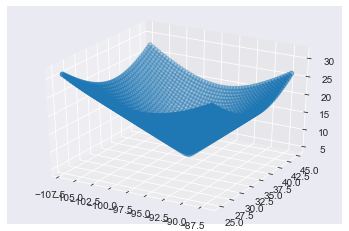

In [123]:
x = np.linspace(oklahoma[0]-10,oklahoma[0]+10)
y = np.linspace(oklahoma[1]-10,oklahoma[1]+10)
x, y = np.meshgrid(x,y)
z = cone((x,y), popt[0],popt[1],popt[2],popt[3],)
z = coneodr(beta,(x,y),)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)